# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
X_train, y_train = train['X'], train['y']
X_test, y_test = test['X'], test['y']

In [4]:
print("Shape of X_train is:", X_train.shape)
print("Shape of y_train is:", y_train.shape)
print("Shape of X_test is:", X_test.shape)
print("Shape of y_test is:", y_test.shape)

Shape of X_train is: (32, 32, 3, 73257)
Shape of y_train is: (73257, 1)
Shape of X_test is: (32, 32, 3, 26032)
Shape of y_test is: (26032, 1)


In [5]:
# Transpose the image arrays
# Let's permute the dimensions of the array to get the data into a more manageable format where the indexes correspond to (image idx, row, column and color channel).
X_train = X_train.transpose((3,0,1,2))
X_test = X_test.transpose((3,0,1,2))
y_train = y_train[:,0]
y_test = y_test[:,0]

print("Shape of X_train is:", X_train.shape)
print("Shape of y_train is:", y_train.shape)
print("Shape of X_test is:", X_test.shape)
print("Shape of y_test is:", y_test.shape)
print('\n')

# # Total Number of Images
print(f"Total Number of Images: {X_train.shape[0] + X_test.shape[0]}")

Shape of X_train is: (73257, 32, 32, 3)
Shape of y_train is: (73257,)
Shape of X_test is: (26032, 32, 32, 3)
Shape of y_test is: (26032,)


Total Number of Images: 99289


## Visualizing Random Sample Images

def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    %matplotlib inline
    
    fig, ax = plt.subplots(nrows, ncols)
    for row in range(nrows):
        for col in range(ncols):
            randint = np.random.choice(img.shape[0],1)[0]
            if img[randint].shape == (32,32,3):
                ax[row, col].imshow(img[randint,:,:,:])    
            else:
                ax[row, col].imshow(img[randint,:,:,0], cmap='gray')
            ax[row, col].axis('off')
            ax[row, col].set_title(f'{y_train[randint,]}')
    plt.show()

In [7]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        randint = np.random.choice(img.shape[0], 1)[0]
        if img[randint].shape == (32, 32, 3):
            ax.imshow(img[randint])
        else:
            ax.imshow(img[randint,:,:,0], cmap='gray')
        ax.axis('off')
        ax.set_title(labels[randint])

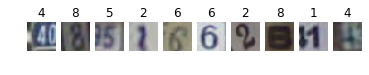

In [8]:
# Visualizing the Training Images
plot_images(X_train, y_train, 1, 10)

## RGB to Grayscale
To speed up our experiments we will convert our images from RGB to Grayscale, which grately reduces the amount of data we will have to process. To convert RBG values to grayscale we can take a weighted sum of the R, G, and B components. For more information see Converting color to grayscale.

$ Y' = 0.2989R + 0.5870G + 0.1140B $

def rgb2gray(images):
    """Convert images from rbg to grayscale
    """
    return np.expand_dims(np.dot(images, [0.2989, 0.5870, 0.1140]), axis=3)

In [9]:
# Converting Image to Grayscale by taking an average across all channels for each pixel, but it can also be done with the above parameters
X_train_gray = np.mean(X_train ,axis=3)[:,:,:,np.newaxis]
X_test_gray = np.mean(X_test, axis=3)[:,:,:,np.newaxis]

In [10]:
print(X_train_gray.shape)
print(X_test_gray.shape)

(73257, 32, 32, 1)
(26032, 32, 32, 1)


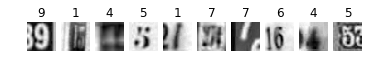

In [11]:
plot_images(X_train_gray, y_train, 1, 10)

In [12]:
np.unique(y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

#### Converting Label 10 -> 0

In [13]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [14]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [15]:
### Splitting the Training into Train and Validation Sets
X_train_gray, X_val_gray, y_train, y_val = train_test_split(X_train_gray, y_train, test_size=0.13, random_state=7)

In [16]:
print(f"Training Set : {X_train_gray.shape}")
print(f"Validation Set : {X_val_gray.shape}")
print(f"Test Set : {X_test_gray.shape}")

Training Set : (63733, 32, 32, 1)
Validation Set : (9524, 32, 32, 1)
Test Set : (26032, 32, 32, 1)


In [17]:
# Removing RGB train, test set to reduce RAM storage occupied by them
del X_train, X_test

In [18]:
X_train_gray.shape

(63733, 32, 32, 1)

## Plot the Grayscale Image

#### Before Normalization

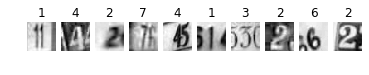

In [19]:
plot_images(X_train_gray, y_train, 1, 10)

In [20]:
train_mean = np.mean(X_train_gray, axis=0)
train_std = np.mean(X_train_gray, axis=0)

X_train_gray_norm = (X_train_gray - train_mean) / train_std
X_test_gray_norm = (X_test_gray - train_mean) / train_std
X_val_gray_norm = (X_val_gray - train_mean) / train_std

#### After Normalization

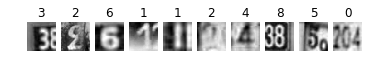

In [21]:
plot_images(X_train_gray_norm, y_train, 1, 10)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [23]:
model = Sequential([
    Flatten(input_shape=(32, 32, 1)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 599,370
Trainable params: 599,370
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
def get_callbacks():
    checkpoint_path = 'model_checkpoints/checkpoint'
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, frequency='epoch', save_weights_only=True, verbose=1)
    early_stopping = EarlyStopping(mode="min", patience=5)
    return (checkpoint, early_stopping)

In [27]:
checkpoint, early_stopping = get_callbacks()
history = model.fit(X_train_gray_norm, y_train, epochs=15, validation_data=(X_val_gray_norm, y_val), callbacks=[checkpoint, early_stopping])

Train on 63733 samples, validate on 9524 samples
Epoch 1/15
63616/63733 [============================>.] - ETA: 0s - loss: 1.2265 - accuracy: 0.6027
Epoch 00001: saving model to model_checkpoints/checkpoint
63733/63733 [==============================] - 67s 1ms/sample - loss: 1.2263 - accuracy: 0.6028 - val_loss: 0.9573 - val_accuracy: 0.7057
Epoch 2/15
63712/63733 [============================>.] - ETA: 0s - loss: 0.8570 - accuracy: 0.7313
Epoch 00002: saving model to model_checkpoints/checkpoint
63733/63733 [==============================] - 63s 987us/sample - loss: 0.8569 - accuracy: 0.7313 - val_loss: 0.8525 - val_accuracy: 0.7375
Epoch 3/15
63648/63733 [============================>.] - ETA: 0s - loss: 0.7444 - accuracy: 0.7685
Epoch 00003: saving model to model_checkpoints/checkpoint
63733/63733 [==============================] - 62s 978us/sample - loss: 0.7444 - accuracy: 0.7685 - val_loss: 0.7384 - val_accuracy: 0.7745
Epoch 4/15
63680/63733 [============================>.] - E

#### Finally, let's replot the accuracy and loss graphs for our history model.

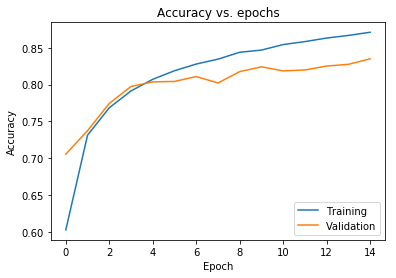

In [28]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

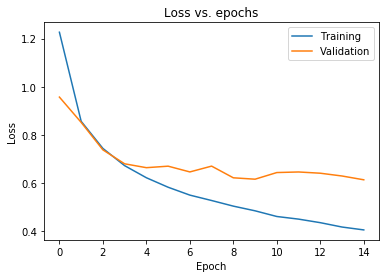

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [30]:
# Evaluate the model on the test set

test_loss, test_acc = model.evaluate(X_test_gray_norm, y_test, verbose=0)
print(f"Test loss: {test_loss:.3f}\nTest accuracy: {100 * test_acc:.2f}%")

Test loss: 0.742
Test accuracy: 80.94%


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [31]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout

In [32]:
ConvModel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu',
                           input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPool2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [33]:
ConvModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_5 (Dense)              (None, 32)               

In [34]:
ConvModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
def get_conv_callbacks():
    checkpoint_path = 'model_conv_checkpoints/checkpoint'
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, frequency='epoch', save_weights_only=True, verbose=1)
    early_stopping = EarlyStopping(mode="min", patience=10)
    return (checkpoint, early_stopping)

In [36]:
checkpoint, early_stopping = get_conv_callbacks()
history = ConvModel.fit(X_train_gray_norm[:32000], y_train[:32000], epochs=5, validation_data=(X_val_gray_norm, y_val), callbacks=[checkpoint, early_stopping])

Train on 32000 samples, validate on 9524 samples
Epoch 1/5
31968/32000 [============================>.] - ETA: 0s - loss: 1.0992 - accuracy: 0.6448
Epoch 00001: saving model to model_conv_checkpoints/checkpoint
32000/32000 [==============================] - 237s 7ms/sample - loss: 1.0986 - accuracy: 0.6450 - val_loss: 0.6114 - val_accuracy: 0.8233
Epoch 2/5
31968/32000 [============================>.] - ETA: 0s - loss: 0.5420 - accuracy: 0.8419
Epoch 00002: saving model to model_conv_checkpoints/checkpoint
32000/32000 [==============================] - 235s 7ms/sample - loss: 0.5417 - accuracy: 0.8420 - val_loss: 0.5307 - val_accuracy: 0.8452
Epoch 3/5
31968/32000 [============================>.] - ETA: 0s - loss: 0.4332 - accuracy: 0.8717
Epoch 00003: saving model to model_conv_checkpoints/checkpoint
32000/32000 [==============================] - 235s 7ms/sample - loss: 0.4331 - accuracy: 0.8717 - val_loss: 0.4593 - val_accuracy: 0.8689
Epoch 4/5
31968/32000 [=========================

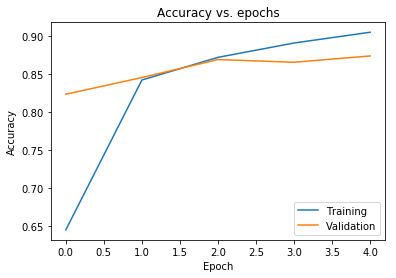

In [37]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

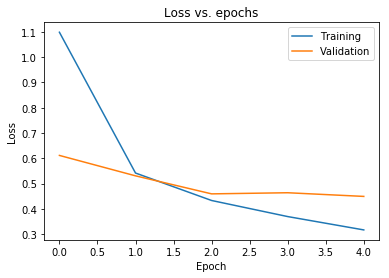

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [39]:
# Evaluate the model on the test set

test_loss, test_acc = ConvModel.evaluate(X_test_gray_norm, y_test, verbose=0)
print(f"Test loss: {test_loss:.3f}\nTest accuracy: {100 * test_acc:.2f}%")

Test loss: 0.529
Test accuracy: 85.39%


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [26]:
def get_mlp_model():
    model = Sequential([
        Flatten(input_shape=(32, 32, 1)),
        Dense(512, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [27]:
def get_conv_model():
    ConvModel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPool2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
    ])
    ConvModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return ConvModel

In [28]:
model_mpl_last_epoch_file = tf.train.latest_checkpoint("model_checkpoints")
model_conv_last_epoch_file = tf.train.latest_checkpoint("model_conv_checkpoints")

In [29]:
def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

#### Test Accuracy for MLP Model

In [30]:
model_mlp = get_mlp_model()
model_mlp.load_weights(model_mpl_last_epoch_file)
get_test_accuracy(model_mlp, X_test_gray_norm, y_test)

accuracy: 0.809


#### Test Accuracy for Conv Model

In [31]:
model_conv = get_conv_model()
model_conv.load_weights(model_conv_last_epoch_file)
get_test_accuracy(model_conv, X_test_gray_norm, y_test)

accuracy: 0.854


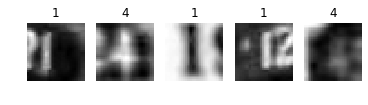

In [32]:
plot_images(X_test_gray_norm, y_test, 1, 5)

In [34]:
predictions_mlp = model_mlp.predict(X_test_gray_norm)
predictions_conv = model_conv.predict(X_test_gray_norm)

In [37]:
predictions_mlp.shape, predictions_conv.shape

((26032, 10), (26032, 10))

In [47]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel(f"Prediction:{predicted_label} | {100*np.max(predictions_array):2.0f}% | (True: {true_label})".format(color=color))

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

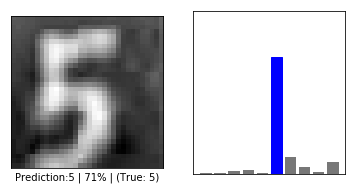

In [48]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions_mlp, y_test, X_test_gray_norm)
plt.subplot(1,2,2)
plot_value_array(i, predictions_mlp, y_test)

In [51]:
randint = np.random.choice(X_test_gray_norm.shape[0], 1)[0]
randint

21819

### Predicted Label by MLP Model

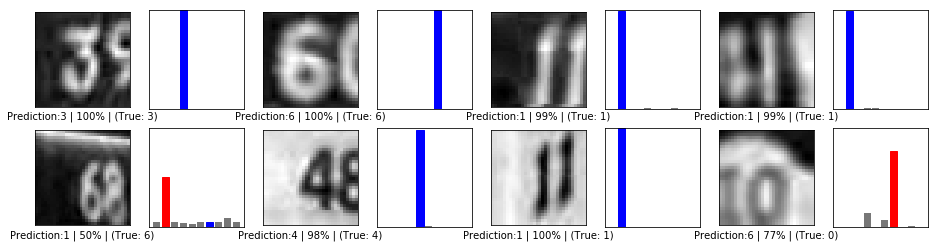

In [58]:
# Plot the Random X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 2
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  randint = np.random.choice(X_test_gray_norm.shape[0], 1)[0]
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(randint, predictions_mlp, y_test, X_test_gray_norm)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(randint, predictions_mlp, y_test)

### Predicted Label by Convolutional Model

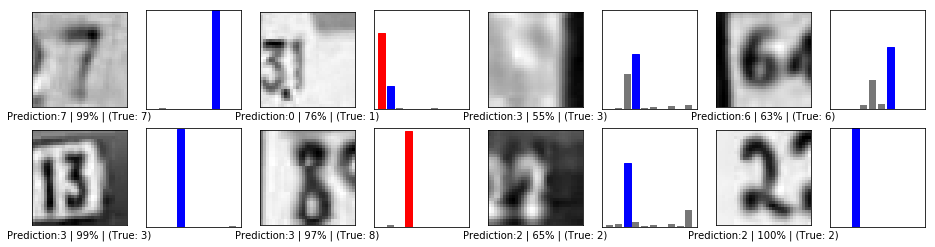

In [60]:
# Plot the Random X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 2
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  randint = np.random.choice(X_test_gray_norm.shape[0], 1)[0]
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(randint, predictions_conv, y_test, X_test_gray_norm)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(randint, predictions_conv, y_test)